# Bearing capacity for shallow foundations

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/foundation_eng/blob/main/notebooks/bearing_capacity.ipynb).




## Setting up the environment

### Required modules

In [1]:
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
    print('Running on CoLab. Installing the required modules...')
    %pip install ipympl &> ~/pip-log.txt &> ~/pip-log.txt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, clear_output

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        "image.cmap": 'cubehelix',
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

## Hansen equation for bearing capacity


$$

q_\mathrm{ult} = c N_c s_c d_c i_c g_c b_c + \bar{q} N_q s_q d_q i_q g_q  b_q + 0.5 \gamma B' N_\gamma s_\gamma d_\gamma i_\gamma g_\gamma b_\gamma
$$


### Functions

In [2]:
def bearing_capacity(P, γ, γ_sat, 𝜙, c, D, Dw, B, L, i, 𝛽, 𝜈, c_f=1):
    """Calculate q_ult of rectangular shallow foundation using Hansen's formula

    Parameters
    ----------
    P : Float
        Load transmited to the foundation
    γ : Float
        Total unit weigth of soil
    γ_sat : Float
        Saturated unit weigth of soil
    𝜙 : Float
        Friction angle
    c : Float
        Envelope intercept ("cohesion")
    D : Float
        Foundation base depth
    Dw : Float
        Freatic level depth
    B : Float
        Short side of the equivalent rectangle of the effective foundation area
    L : Float
        Long side of the equivalent rectangle of the effective foundation area
    i : Float
        Load inclination (measured from the normal to foundation base)
    𝛽 : Float
        Slope inclination (measured from the horizontal)
    𝜈 : Float
        Base inclination (measured from the horizontal)
    c_f : int, optional
        Factor to affect cohesion to account for adhesion at base, by default 1

    Returns
    -------
    Float
        Bearing capacity
    """
    𝜙_r = np.radians(𝜙)
    H = P * np.sin(np.radians(i))
    V = P * np.cos(np.radians(i))
    # Effective overburden pressure at base level
    d = Dw - D  # Distance between watertable and foundation base
    γ_sub = (γ_sat - 9.8)
    if Dw < D:  # Case 1: Dw between surface and foundation base depth
        q = (Dw * γ) + (D - Dw) * γ_sub
    elif d < B:  # Case 2: Dw between surface and foundation base depth + D
        q = γ_sub + (γ - γ_sub) * d / B
    else:  # Case 3: Dw below foundation base depth + D
        q = γ * D
    # Bearing capacity factors
    Nq = np.exp(np.pi * np.tan(𝜙_r)) * (np.tan(np.radians(45 + 𝜙 / 2))) ** 2
    Nc = (Nq - 1) / np.tan(𝜙_r)
    Nγ = 1.5 * (Nq - 1) * np.tan(𝜙_r)
    # Shape factors
    sc = 0.2 * B / L if 𝜙 == 0 else 1 + (Nq / Nc) * (B / L)
    sq = 1 + np.sin(𝜙_r) * B / L
    sγ = 1 - 0.4 * B / L
    # Depth factors
    k = D / B if D / B <= 1 else np.arctan(D / B)
    dc = 0.4 * k if 𝜙 == 0 else 1 + 0.4 * k
    dq = 1 + 2 * k * np.tan(𝜙_r) * (1 - np.sin(𝜙_r)) ** 2
    dγ = 1
    # Inclination factors
    α = 5
    c_a = c * c_f  # Adhesion between base and soil
    Af = B * L  # Effective area
    iq = (1 - (0.5 * H) / (V + Af * c_a / np.tan(𝜙_r))) ** α
    if 𝜙 == 0:
        ic = 0.5 - 0.5 * (1 - H / (Af * c_a)) ** 0.5
    else:
        ic = iq - (1 - iq) / (Nq - 1)
    iγ = (1 - (0.7 - 𝜈 / 450) * H / (V + Af * c_a / np.tan(𝜙_r))) ** α
    # Ground factors
    gc = 𝛽 / 147 if 𝜙 == 0 else 1 + 𝛽 / 147
    gq = (1 - 0.5 * np.tan(np.radians(𝛽))) ** 5
    gγ = gq
    # Base factors
    bc = 𝜈 / 147 if 𝜙 == 0 else 1 + 𝜈 / 147
    bq = np.exp(-2 * 𝜈 * np.tan(𝜙_r))
    bγ = np.exp(-2.7 * 𝜈 * np.tan(𝜙_r))
    # Bearing capacity
    q_ult_c = c * Nc * sc * dc * ic * gc * bc
    q_ult_q = q * Nq * sq * dq * iq * gq * bq
    q_ult_γ = 0.5 * γ * B * Nγ * sγ * dγ * iγ * gγ * bγ
    q_ult = q_ult_c + q_ult_q + q_ult_γ
    if 𝜙 == 0:
        q_ult = 5.14 * c * (1 + sc + dc - ic - bc - gc)
    return q_ult


In [3]:
def plot_abacus(ranges, P, γ, γ_sat, 𝜙, c, Dw, i, 𝛽, 𝜈, same_scale_y=False, c_f=1, **kwargs):
    figsize = kwargs.get('figsize')
    D_range = ranges['D']
    B_range = ranges['B']
    L_B_range = ranges['L/B']
    fig, axs = plt.subplots(ncols=1, nrows=len(D_range), figsize=figsize,
        sharey=same_scale_y, sharex=True)
    for ax in axs:
        ax.set_prop_cycle("color", plt.cm.brg(np.linspace(0, 1, len(L_B_range) + 1)))
    for ax, D in zip(axs, D_range):
        for L_B in L_B_range:
            q_ult = []
            for B in B_range:
                L = L_B * B
                q_ult.append(
                    bearing_capacity(P, γ, γ_sat, 𝜙, c, D, Dw, B, L, i, 𝛽, 𝜈, c_f=1)
                )
            ax.plot(B_range, q_ult, ls="--", marker="o", ms=5, mfc='w', label=f"$L/B=${L_B:.1f}")
            ax.set_title(f"$D=${D:.1f} m", fontsize='medium')
    for ax in axs:
        ax.set(ylabel="$q_\mathrm{ult}$  [kPa]")
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.grid(True, which="major", color="#999999", linestyle="--")
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')
    axs[-1].set(xlabel="$B$  [m]")
    # fig.tight_layout()
    plt.show()

### Running a single case

In [4]:
P = 100  # [kN]
γ = 16.5  # [kN/m³]
γ_sat = 16.5  # [kN/m³]
𝜙 = 25  # [°]
c = 20  # [kPa]
D = 1.5  # [m]
B = 2.0  # [m]
L = 2.0   # [m]
Dw = 10  # [m]
i = 0  # [°]
𝛽 = 0  # [°]
𝜈 = 0  # [°]
q_ult = bearing_capacity(P, γ, γ_sat, 𝜙, c, D, Dw, B, L, i, 𝛽, 𝜈, c_f=1)
q_ult

1345.8068402385843

In [5]:
P = 100  # [kN]
γ = 16.5  # [kN/m³]
γ_sat = 16.5  # [kN/m³]
𝜙 = 25  # [°]
c = 20  # [kPa]
D = 1.5  # [m]
B = 2.0  # [m]
L = 3.0   # [m]
Dw = 10  # [m]
i = 0  # [°]
𝛽 = 0  # [°]
𝜈 = 0  # [°]
q_ult = bearing_capacity(P, γ, γ_sat, 𝜙, c, D, Dw, B, L, i, 𝛽, 𝜈, c_f=1)
print(f'q_ult = {q_ult:.2f}')

q_ult = 1222.43


### Running multiple cases to plot abacus

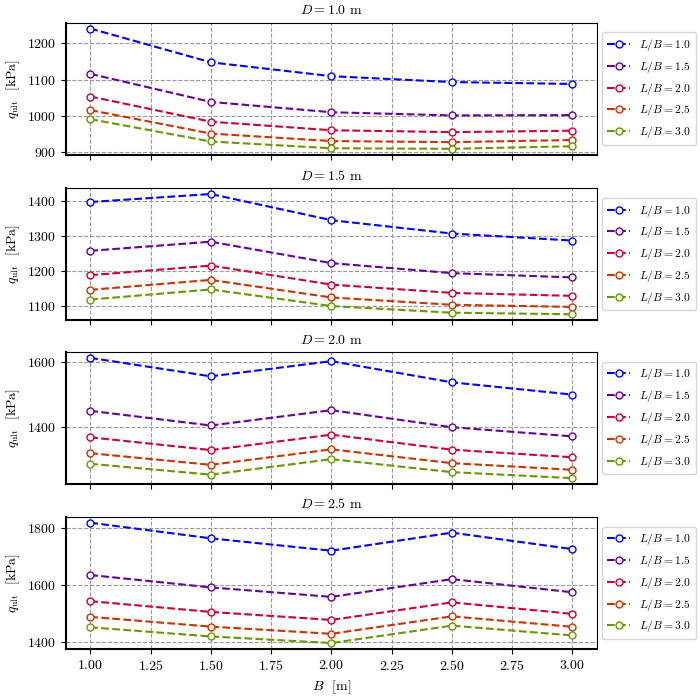

In [13]:
P = 100  # Load (relevant only if inclined) [kN]
γ = 16.5  # Total unit weigth of soil [kN/m³]
γ_sat = 19  # Saturated unit weigth of soil [kN/m³]
𝜙 = 25  # Friction angle [°]
c = 20  # Envelope intercept [kPa]
Dw = 10  # Watertable depth [m]
i = 0  # Load inclination (measured from the normal to foundation base) [°]
𝛽 = 0  # Slope inclination (measured from the horizontal) [°]
𝜈 = 0  # Foundation base inclination (measured from the horizontal) [°]
ranges = {  # Note: You can add or remove items from the lists
    'D': [1, 1.5, 2, 2.5],  # Foundation base depth [m]
    'B': [1, 1.5, 2, 2.5, 3],  # Foundation width [m]
    'L/B': [1, 1.5, 2, 2.5, 3]  # Length to base ratio [-]
}

same_scale_y = False  # Change to True if want the same scale

plot_abacus(ranges, P, γ, γ_sat, 𝜙, c, Dw, i, 𝛽, 𝜈, same_scale_y, c_f=1, figsize=[7, 7])


# Setup for html output

In [7]:
%%html
<style> div.jupyter-widgets.widget-label {display: none;} </style>